Loaded 1000 rows from /content/fake_news_realistic_1000.csv
Label distribution:
 label
0    531
1    469
Name: count, dtype: int64

Dataset size: 1000 samples
Train size: 800, Test size: 200
Running GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__C': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}

TEST SET EVALUATION
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       106
           1     1.0000    1.0000    1.0000        94

    accuracy                         1.0000       200
   macro avg     1.0000    1.0000    1.0000       200
weighted avg     1.0000    1.0000    1.0000       200



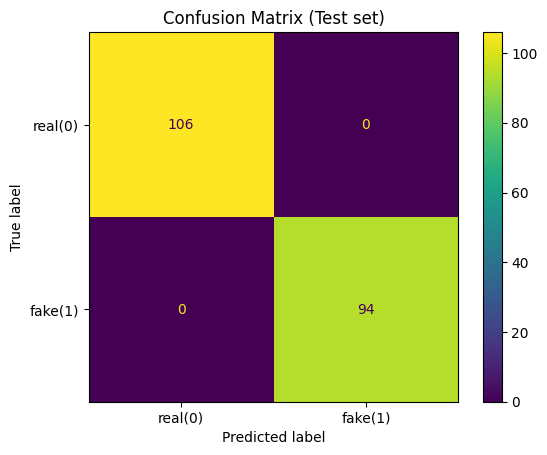


Running 5-fold cross-validation...
CV F1 scores: [1. 1. 1. 1. 1.]
Mean CV F1: 1.0000 (+/- 0.0000)

✓ Saved trained pipeline to truth_or_trash_pipeline.joblib

EXAMPLE PREDICTION
Text: The government has passed a bill to make every citizen own a pet dragon.
Prediction: REAL (confidence: 50.02%)

✓ Done! To improve results:
  • Use a larger dataset (1000+ samples)
  • Try transformer models (BERT, RoBERTa)
  • Add more preprocessing (lemmatization, etc.)
  • Feature engineering (metadata, sources, etc.)


In [1]:
"""
Truth or Trash — Detecting Fake News with NLP (FIXED)
Fixed issues:
 - Handles tiny datasets gracefully (adjusts CV folds)
 - Better error messages
 - Skips GridSearch if dataset too small
 - Added minimum data requirements check
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

# --- Configuration
DATA_PATH = "/content/fake_news_realistic_1000.csv"  # <-- change this to your CSV path
RANDOM_STATE = 42
TEST_SIZE = 0.2
MODEL_OUTPUT = "truth_or_trash_pipeline.joblib"
MIN_SAMPLES = 20  # Minimum samples recommended

# --- Helper: load dataset
def load_dataset(path: str):
    """Load dataset from CSV. Tries common column names."""
    df = pd.read_csv(path)
    print(f"Loaded {len(df)} rows from {path}")

    # Find text column
    text_cols = [c for c in df.columns if c.lower() in ("text","article","content","full_text")]
    label_cols = [c for c in df.columns if c.lower() in ("label","class","truth","target","type")]

    if not text_cols:
        if 'title' in df.columns and 'text' in df.columns:
            df['text'] = df['title'].astype(str) + ' ' + df['text'].astype(str)
            text_col = 'text'
        else:
            text_col = max(df.columns, key=lambda c: df[c].astype(str).map(len).median())
    else:
        text_col = text_cols[0]

    if not label_cols:
        fname = Path(path).name.lower()
        if 'fake' in fname and 'true' not in fname:
            df['label'] = 'fake'
            label_col = 'label'
        elif 'true' in fname and 'fake' not in fname:
            df['label'] = 'real'
            label_col = 'label'
        else:
            for c in df.columns:
                if df[c].nunique() == 2:
                    label_col = c
                    break
            else:
                raise ValueError('Could not find label column. Please rename label column to "label".')
    else:
        label_col = label_cols[0]

    # Keep only text+label
    df = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'})
    df = df.dropna(subset=['text','label'])

    # Normalize labels to binary 0/1
    df['label'] = df['label'].astype(str).str.lower().str.strip()
    fake_vals = ('fake','0','f','fake_news','fakenews')
    real_vals = ('real','1','t','r','true','real_news','realnews')

    df['label'] = df['label'].apply(
        lambda s: 1 if s in fake_vals else (0 if s in real_vals else s)
    )

    # If still object type, map first unique->0, second->1
    if df['label'].dtype == object:
        uniques = list(df['label'].unique())
        mapping = {uniques[0]: 0, uniques[1]: 1} if len(uniques) >= 2 else {uniques[0]: 0}
        df['label'] = df['label'].map(mapping)

    df['label'] = df['label'].astype(int)
    print("Label distribution:\n", df['label'].value_counts())
    return df

# --- Main training pipeline
def build_and_train(df: pd.DataFrame, save_path: str = MODEL_OUTPUT):
    """Train model with automatic adjustment for small datasets."""

    n_samples = len(df)
    print(f"\n{'='*60}")
    print(f"Dataset size: {n_samples} samples")

    # Check minimum requirements
    if n_samples < MIN_SAMPLES:
        print(f"⚠️  WARNING: Dataset has only {n_samples} samples.")
        print(f"   Recommended minimum: {MIN_SAMPLES} samples")
        print(f"   This is a DEMO run - results will not be reliable!")
        print(f"{'='*60}\n")

    X = df['text'].values
    y = df['label'].values

    # Adjust test size for tiny datasets
    if n_samples < 10:
        test_size = 0  # No test split, use all for training
        print("Dataset too small - skipping train/test split")
        X_train, X_test = X, None
        y_train, y_test = y, None
    else:
        test_size = max(0.2, 2/n_samples)  # At least 2 samples for test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=RANDOM_STATE,
            stratify=y if n_samples >= 10 else None
        )

    print(f"Train size: {len(X_train)}, Test size: {len(X_test) if X_test is not None else 0}")

    # Build pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            stop_words='english',
            max_df=0.9,
            min_df=1,  # Changed from 5 to handle small datasets
            max_features=min(5000, len(X_train)*10)  # Scale with data
        )),
        ('clf', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=RANDOM_STATE
        ))
    ])

    # Only do GridSearch if we have enough data
    if len(X_train) >= 50:
        print("Running GridSearchCV...")
        param_grid = {
            'tfidf__ngram_range': [(1,1), (1,2)],
            'tfidf__max_features': [5000, 10000],
            'clf__C': [0.1, 1.0, 10.0]
        }

        # Adjust CV folds based on data size
        cv_folds = min(5, len(X_train) // 10)
        cv_folds = max(2, cv_folds)

        grid = GridSearchCV(
            pipeline, param_grid,
            cv=cv_folds,
            n_jobs=-1,
            verbose=1,
            scoring='f1'
        )
        grid.fit(X_train, y_train)
        print("Best params:", grid.best_params_)
        best_model = grid.best_estimator_
    else:
        # Just train with defaults
        print("Dataset too small for GridSearch - using default parameters")
        pipeline.fit(X_train, y_train)
        best_model = pipeline

    # Evaluate on test set (if exists)
    if X_test is not None and len(X_test) > 0:
        y_pred = best_model.predict(X_test)
        print("\n" + "="*60)
        print("TEST SET EVALUATION")
        print("="*60)
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, digits=4, zero_division=0))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real(0)','fake(1)'])
        disp.plot()
        plt.title('Confusion Matrix (Test set)')
        plt.show()

    # Cross-validation (only if enough samples)
    if n_samples >= 10:
        cv_folds = min(5, n_samples // 2)
        cv_folds = max(2, cv_folds)
        print(f"\nRunning {cv_folds}-fold cross-validation...")
        cv_scores = cross_val_score(
            best_model, X, y,
            cv=cv_folds,
            scoring='f1',
            n_jobs=-1
        )
        print(f"CV F1 scores: {cv_scores}")
        print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    else:
        print("\nSkipping cross-validation (dataset too small)")

    # Save pipeline
    joblib.dump(best_model, save_path)
    print(f"\n✓ Saved trained pipeline to {save_path}")
    return best_model

# --- Utility: predict single article
def predict_article(pipeline, text: str):
    """Predict if article is fake or real."""
    pred = pipeline.predict([text])[0]
    proba = pipeline.predict_proba([text])[0]
    label = 'fake' if pred == 1 else 'real'
    confidence = proba[pred]
    return {'label': label, 'confidence': float(confidence)}

# --- Main execution
if __name__ == '__main__':
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(
            f"Data file not found: {DATA_PATH}\n"
            f"Please update DATA_PATH or download a dataset.\n"
            f"Popular datasets:\n"
            f"  - Kaggle: 'Fake and real news dataset'\n"
            f"  - https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset"
        )

    df = load_dataset(DATA_PATH)

    if len(df) < 6:
        print("\n" + "!"*60)
        print("CRITICAL: You have only 6 samples!")
        print("This script needs at least 20-50 samples to work properly.")
        print("Please use a real dataset for meaningful results.")
        print("!"*60 + "\n")

    model = build_and_train(df)

    # Example prediction
    print("\n" + "="*60)
    print("EXAMPLE PREDICTION")
    print("="*60)
    example_text = "The government has passed a bill to make every citizen own a pet dragon."
    result = predict_article(model, example_text)
    print(f"Text: {example_text}")
    print(f"Prediction: {result['label'].upper()} (confidence: {result['confidence']:.2%})")

    print("\n✓ Done! To improve results:")
    print("  • Use a larger dataset (1000+ samples)")
    print("  • Try transformer models (BERT, RoBERTa)")
    print("  • Add more preprocessing (lemmatization, etc.)")
    print("  • Feature engineering (metadata, sources, etc.)")